<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Multimodal Agentic RAG with Document Retrieval (ColPali), Vision Language Model (ColQwen2), Amazon Nova and CrewAI
</h1>.

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Loading the PDF files (Dataset)
</h1>

In [1]:
import requests
import os

# Download pdfs from different sources 
def download_pdf(pdfs, output_dir):
    for name, url in pdfs.items():
        response = requests.get(url)
        pdf_path = os.path.join(output_dir, f"{name}.pdf")

        with open(pdf_path, "wb") as f:
            f.write(response.content)

        print(f"Downloaded {name} to {pdf_path}")

In [2]:
pdfs = {
    "Transformers": "https://arxiv.org/pdf/1706.03762.pdf",  
    "DSPy": "https://arxiv.org/pdf/2310.03714.pdf", 
    "ColPali": "https://arxiv.org/pdf/2407.01449.pdf",
}

# Downloading the PDF files 
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

download_pdf(pdfs, output_dir)


Downloaded Transformers to ./data/Transformers.pdf
Downloaded DSPy to ./data/DSPy.pdf
Downloaded ColPali to ./data/ColPali.pdf


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Converting PDF to Images 
</h1>


In [3]:
import os
from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):

    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images

In [4]:
all_images = convert_pdfs_to_images(output_dir)
all_images

{0: [<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Visualizing the images
</h1>

In [5]:
from matplotlib import pyplot as plt

def display_image_grid(images, num_cols=8, figsize=(15, 10)):
    """
    Display a grid of images using matplotlib.
    
    Args:
        images: List of images to display
        num_cols: Number of columns in the grid (default: 8)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate needed rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flat  # Flatten axes array for easier iteration
    
    # Display images
    for i in range(num_cols * num_rows):
        ax = axes[i]
        if i < num_images:
            ax.imshow(images[i])
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

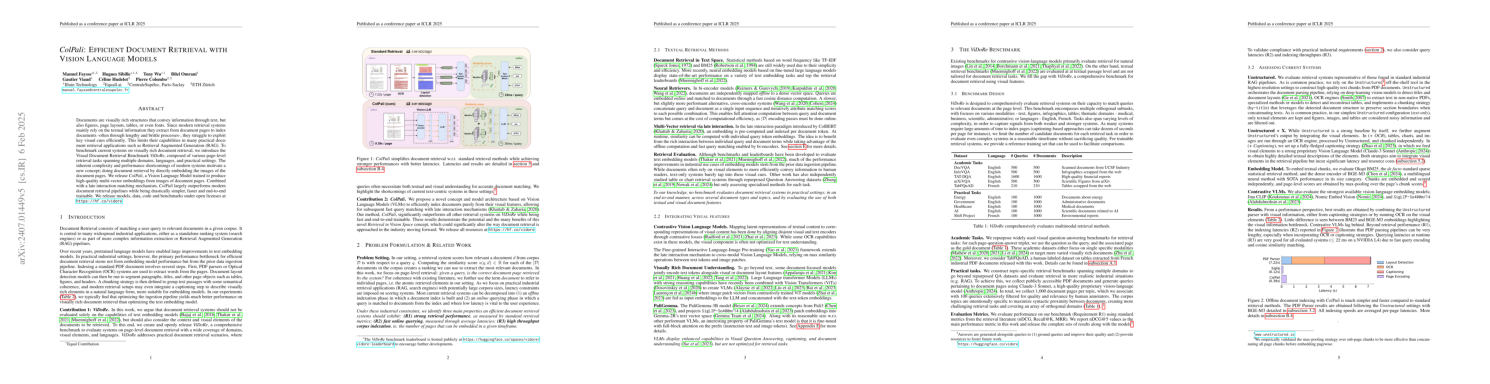

In [6]:
display_image_grid(all_images[1][:5], num_cols=5)

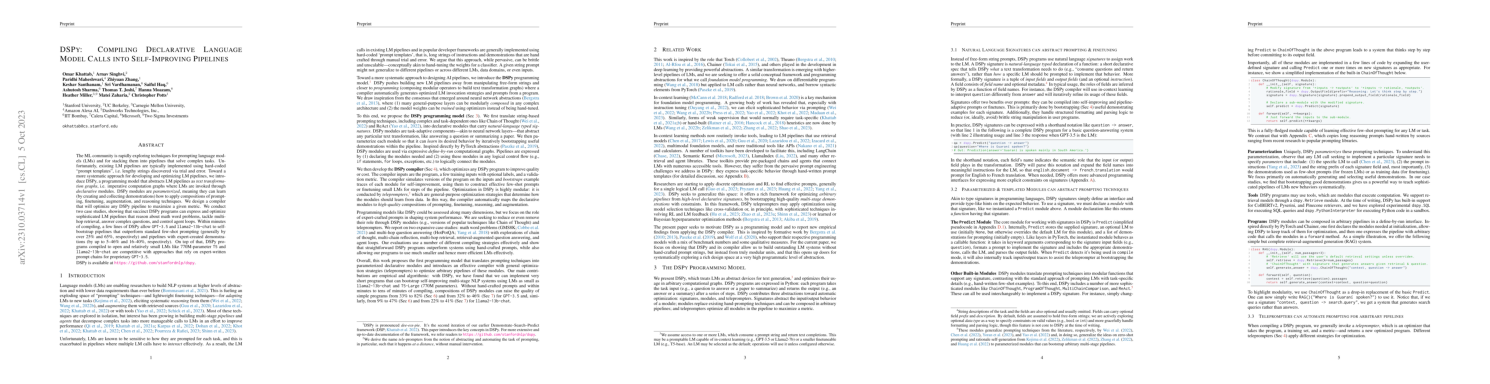

In [7]:
display_image_grid(all_images[0][:5], num_cols=5)

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  ColPali Multimodal Document Retrieval Model
</h1>

In [8]:
import torch 

# Check if CUDA/MPS is available
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{device = }")

device = 'mps'


### Create the ColPali Multimodal Document Retrieval Model

In [9]:
from byaldi import RAGMultiModalModel

## Initialize the ColPali Multimodal Document Retrieval Model
model_name = "vidore/colpali-v1.2"
myRAG = RAGMultiModalModel.from_pretrained(model_name,
                                           device=device)


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
myRAG.index(input_path=output_dir, 
            index_name="research_papers", 
            store_collection_with_index=False, 
            overwrite=True)

overwrite is on. Deleting existing index research_papers to build a new one.
Indexing file: data/DSPy.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 t

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of document 1 to index.
Added page 9 of document 1 to index.
Added page 10 of document 1 to index.
Added page 11 of document 1 to index.
Added page 12 of document 1 to index.
Added page 13 of document 1 to index.
Added page 14 of document 1 to index.
Added page 15 of document 1 to index.
Added page 16 of document 1 to index.
Added page 17 of document 1 to index.
Added page 18 of document 1 to index.
Added page 19 of document 1 to index.
Added page 20 of document 1 to index.
Added page 21 of document 1 to index.
Added page 22 of document 1 to index.
Added page 23 of document 1 to index.
Added page 24 of document 1 to index.
Added page 25 of document 1 to index.
Added page 26 of document 1 to index.
Index exported to .by

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Added page 1 of document 2 to index.
Added page 2 of document 2 to index.
Added page 3 of document 2 to index.
Added page 4 of document 2 to index.
Added page 5 of document 2 to index.
Added page 6 of document 2 to index.
Added page 7 of document 2 to index.
Added page 8 of document 2 to index.
Added page 9 of document 2 to index.
Added page 10 of document 2 to index.
Added page 11 of document 2 to index.
Added page 12 of document 2 to index.
Added page 13 of document 2 to index.
Added page 14 of document 2 to index.
Added page 15 of document 2 to index.
Index exported to .byaldi/research_papers
Index exported to .byaldi/research_papers


{0: 'data/DSPy.pdf', 1: 'data/ColPali.pdf', 2: 'data/Transformers.pdf'}

### Retrieving Documents with the Document Retrieval Model


In [11]:
text_query = "What is proposed in the DSPy programming model ?"

results = myRAG.search(text_query, k=5)
results

[{'doc_id': 0, 'page_num': 2, 'score': 18.25, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 1, 'score': 16.875, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 11, 'score': 16.625, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 6, 'score': 16.5, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 31, 'score': 15.8125, 'metadata': {}, 'base64': None}]

In [12]:
def get_matched_images(results, all_images):
    matched_images = []

    for result in results:
        doc_id = result["doc_id"]
        page_num = result["page_num"]
        matched_images.append(
            all_images[doc_id][page_num - 1]
        )  

    return matched_images

In [13]:
matched_images = get_matched_images(results, all_images)
matched_images

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

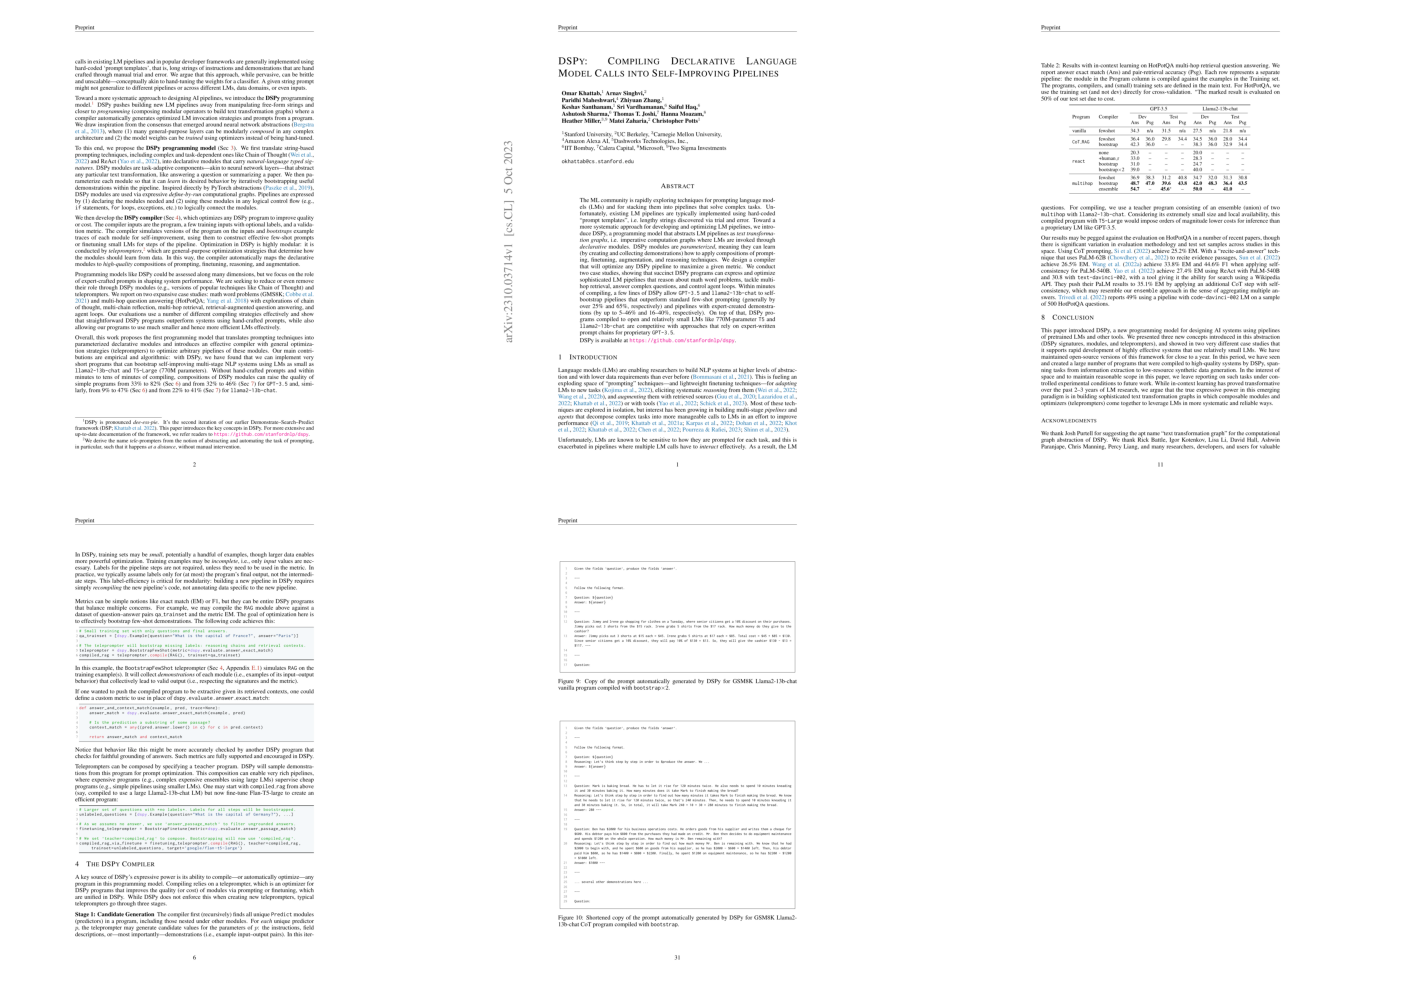

In [14]:
display_image_grid(matched_images, num_cols=3)

In [15]:
from PIL import Image
import os

def save_images_as_png(image_list, output_dir="matched_images"):
    """
    Convert a list of PIL images to PNG format and save them.

    :param image_list: List of PIL image objects.
    :param output_dir: Directory where images will be saved.
    :return: List of file paths for the saved PNG images.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    file_paths = []                         # List to store file paths

    for idx, img in enumerate(image_list):
        file_path = os.path.join(output_dir, f"image_{idx+1}.png")
        img.save(file_path, format="PNG")
        file_paths.append(file_path)       # Add file path to the list

    return file_paths 

In [16]:
matched_items = save_images_as_png(matched_images)
print(matched_items)  

['matched_images/image_1.png', 'matched_images/image_2.png', 'matched_images/image_3.png', 'matched_images/image_4.png', 'matched_images/image_5.png']


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Generation with Bedrock Nova
</h1>

In [17]:
import boto3
import base64

def read_and_encode_image(image_path: str):

    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()
        
    base64_encoded = base64.b64encode(image_bytes).decode('utf-8')
    # Determine the image format (supported formats: jpg, jpeg, png, gif, webp)
    image_format = Image.open(image_path).format.lower()

    message_content = {
                    "image": {
                        "format": image_format,
                        "source": {"bytes": image_bytes},
                    }
                }
    
    return message_content


def send_images_to_model_using_converse(matched_items: list, query: str, model_id: str):

    system_prompt = 'You are a helpful assistant for question answering. Given the context, answer the question in details, and if needed format the code in markdown.'

    image_list = []
    for image_path in matched_items:
        image_list.append({
            "image_path": image_path, 
        })

    content_list = []
    for img in image_list:
        message_content = read_and_encode_image(img['image_path'])
        content_list.append(message_content)
    
    content_list.append({"text": query})
    system = [ { "text": system_prompt } ]
    
    # Define a "user" message including both the image and a text prompt.
    messages = [
        {
            "role": "user",
            "content": content_list,
        }
    ]
    
    # Configure the inference parameters.
    inf_params = {"temperature": .3, "topP": 0.1}
    
    # Initialize the Bedrock client
    client = boto3.client('bedrock-runtime', region_name='us-east-1')

    response = client.converse(
        modelId=model_id, 
        messages=messages,
        system=system, 
        inferenceConfig=inf_params
    )
    
    # Print Response
    output_message = response["output"]["message"]["content"][0]["text"]

    return output_message

In [18]:
PRO_MODEL_ID = "amazon.nova-pro-v1:0"
LITE_MODEL_ID = "amazon.nova-lite-v1:0"
MICRO_MODEL_ID = "amazon.nova-micro-v1:0"

response = send_images_to_model_using_converse(matched_items=matched_items, query=text_query, model_id=PRO_MODEL_ID)
print(response)

The DSPy programming model pushes building new LM pipelines away from manipulating free-form strings and closer to programming (composing modular operators to build text transformation graphs) where a compiler automatically generates optimized invocation strategies and prompts from a program.


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Building an Agentic RAG System with CrewAI
</h1>

In [19]:
# from crewai import Agent, Task, Crew, LLM
# from crewai_tools import tool
# from langchain_community.tools import DuckDuckGoSearchRun